### Search using facebook FAISS
[faiss](https://github.com/facebookresearch/faiss)

In [127]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [159]:
defFile1 = "primitiveDef.json"
defFile2 = "skillDef.json"
defFile3 = "taskDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile1)) as json_file:
    defWord1 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile2)) as json_file:
    defWord2 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile3)) as json_file:
    defWord3 = json.load(json_file)


defWord = defWord1 + defWord2 + defWord3

print(len(defWord))

556


# Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [160]:
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

print(len(defSing))

334


In [161]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2')
# create sentence embeddings
sentence_embeddings = model.encode(defSing)
sentence_embeddings.shape
#print(sentence_embeddings)

(334, 768)

Here he use the clustering provided in the [faiss-wiki](https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization)

In [5]:
import faiss

d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(sentence_embeddings)
index.ntotal
print(len(sentence_embeddings[0]))

768


In [6]:
# We decompose with sklearn PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(sentence_embeddings)

x = principalComponents[:,0].tolist()
y = principalComponents[:,1].tolist()
principalComponents = np.ascontiguousarray(principalComponents)

# We decompose with faiss PCA
mat = faiss.PCAMatrix(768, 2)
mat.train(sentence_embeddings)
assert mat.is_trained
tr = mat.apply_py(sentence_embeddings)
xf = tr[:,0].tolist()
yf = tr[:,1].tolist()

Here we apply Kmeans clustering from faiss

In [304]:
# dataset = tr
# dataset = principalComponents
dataset = sentence_embeddings

d = dataset.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(dataset)
index.ntotal
ncentroids = 35
niter = 20
verbose = True
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(dataset)
print(len(kmeans.centroids))

35


In [9]:
D, I = kmeans.index.search(dataset, 1)
#print(D)
#print(I[:,0])
Ilist = I[:,0].tolist()
Dlist = D[:,0].tolist()
#print(Ilist)
d = {'primitive':defSing, 'cluster':Ilist, 'distance':Dlist, 'x': xf, 'y': yf}
#print(d)

cluster = pd.DataFrame(d)
#print(cluster.head())


In [ ]:
# Create scatter upon cluster type
ax1 = cluster.plot.scatter(x='x', y='y', c='cluster', colormap='viridis')    

for idx, row in cluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

# Try the tree approach branches
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# We can apply the links directly on the figure:
#https://stackoverflow.com/questions/40871268/how-to-add-hyperlink-to-pdf-using-matplotlib


In [ ]:
byCluster = cluster.groupby('cluster')

print(len(byCluster))

for clusterNr in range(len(byCluster)):
  #print(clusterGroup)

  displayCluster = byCluster.get_group(clusterNr)

  #print(displayCluster)

  ax1 = displayCluster.plot.scatter(x='x', y='y')

  # Plot name for each datapoint
  for idx, row in displayCluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

  #plt.savefig("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/out/" + str(clusterNr) + ".png")
    

Here we apply agglomerative clustering from scipy following this [guide](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

In [147]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))

335


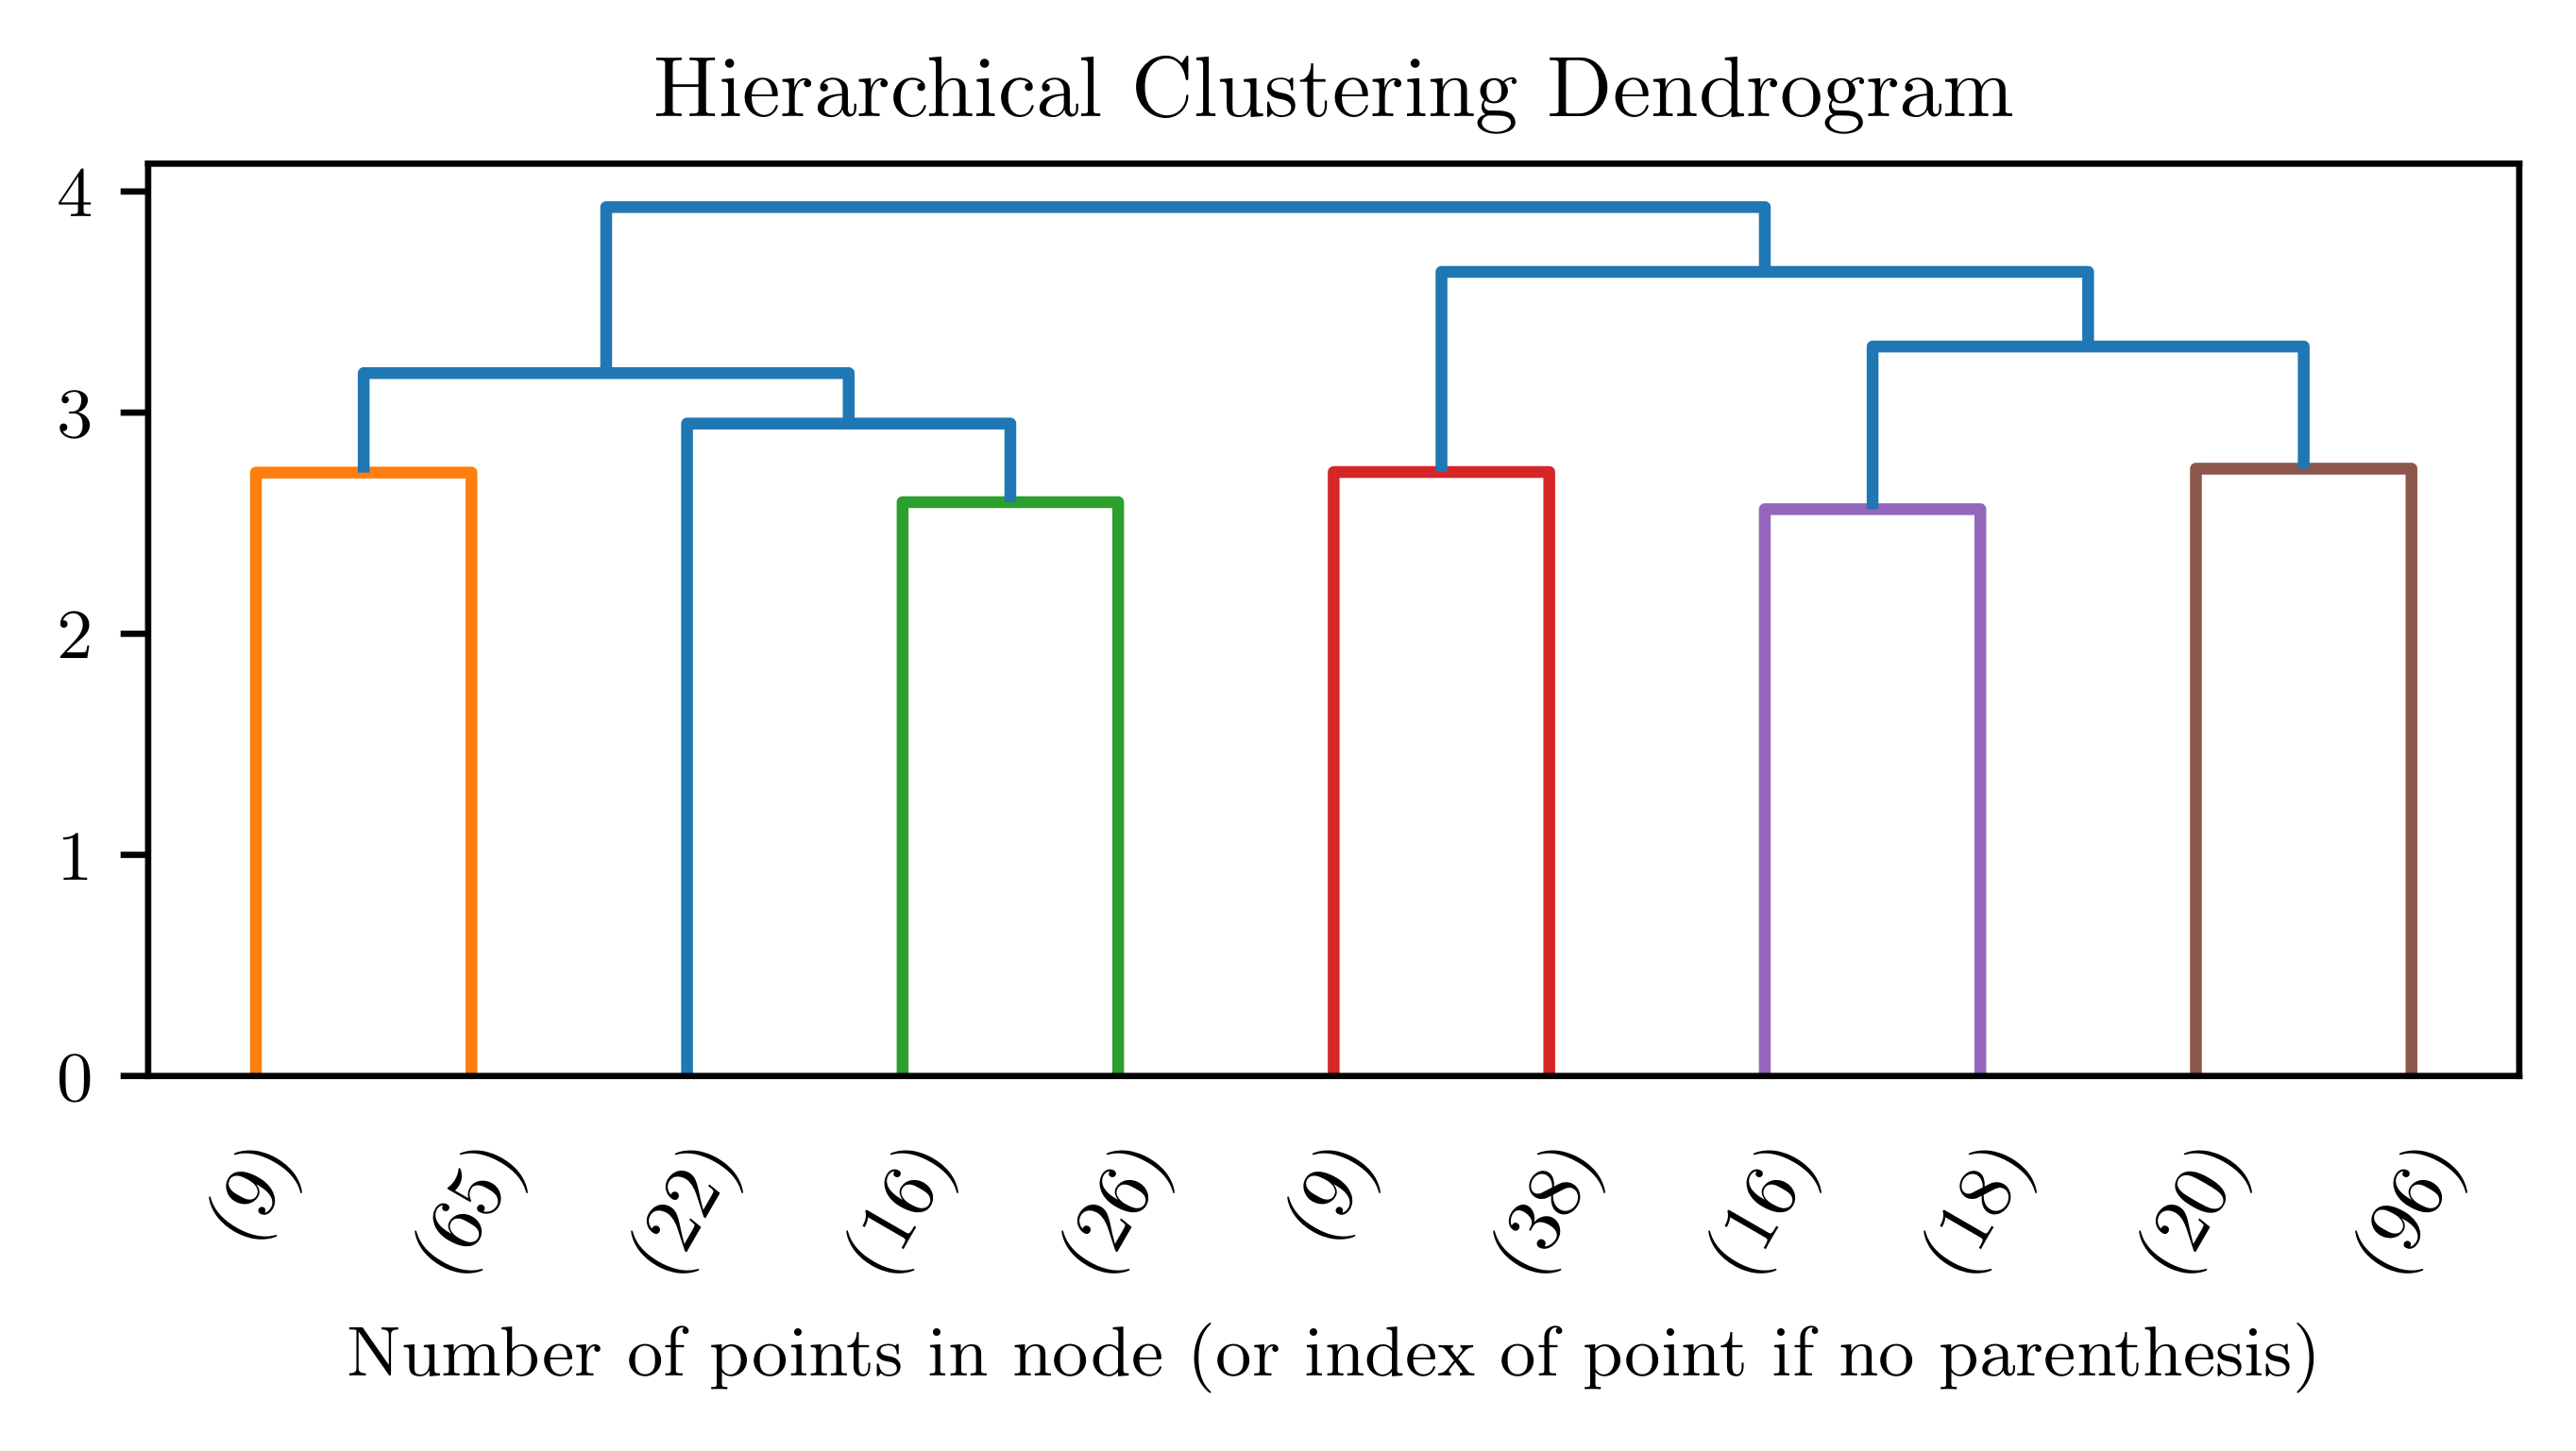

In [149]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendo = dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix, dendo

plt.figure(figsize=(3240/600, 1280/600), dpi=600)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

p = 11
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_rotation=60.,leaf_font_size=10.)
#linkageMatrix, dendoPlot = plot_dendrogram(model, leaf_rotation=60.,leaf_font_size=3.)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/denogrammClusteringRaw.png', dpi=600, bbox_inches = 'tight')
#print(dendoPlot["leaves"])

label = fcluster(linkageMatrix, p, criterion='maxclust')

#print(label)

d = {'primitive': defSing, 'label':label}
#print(d)

hierarchies = pd.DataFrame(d)


As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [150]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# group by "X" column
groups = hierarchies.groupby('label')

labels = []
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words = stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)


    
    labels.append(matchedKeywords)

    # put keywords on the hierechical clustering

print(labels)

GROUP: 1
['compare', 'identity']
compare-identity
GROUP: 2
['feed', 'multi']
feed-multi
GROUP: 3
['hand', 'movement']
hand-movement
GROUP: 4
['screw', 'ptp']
screw-ptp
GROUP: 5
['location', 'place']
location-place
GROUP: 6
['gripper', 'grip']
gripper-grip
GROUP: 7
['grasp', 'grab']
grasp-grab
GROUP: 8
['drill', 'cool']
drill-cool
GROUP: 9
['fluid', 'solder']
fluid-solder
GROUP: 10
['button', 'push']
button-push
GROUP: 11
['attach', 'connect']
attach-connect
['compare-identity', 'feed-multi', 'hand-movement', 'screw-ptp', 'location-place', 'gripper-grip', 'grasp-grab', 'drill-cool', 'fluid-solder', 'button-push', 'attach-connect']


350
16


Text(0.5, 0, 'Keywords expressing each cluster')

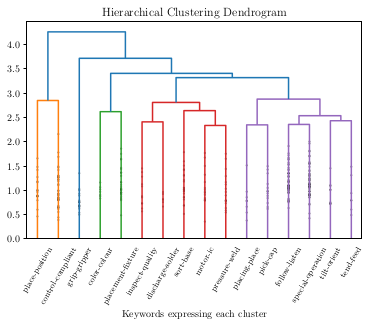

In [279]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))


temp = {dendoPlot["leaves"][ii]: labels[ii] for ii in range(len(dendoPlot["leaves"]))}

print(len(dendoPlot["leaves"]))

def llf(xx):
    #print("{} - custom label!".format(temp[xx]))
    return "{}".format(temp[xx])

plt.title("Hierarchical Clustering Dendrogram")
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_label_func=llf,leaf_rotation=60.,leaf_font_size=8., show_contracted=True)
plt.xlabel("Keywords expressing each cluster")

We now follow the guide of topic modelling, [guide](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [166]:
n_neighbors=5
n_components=2

import umap
umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components, 
                            metric='cosine').fit_transform(sentence_embeddings)

In [167]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

17


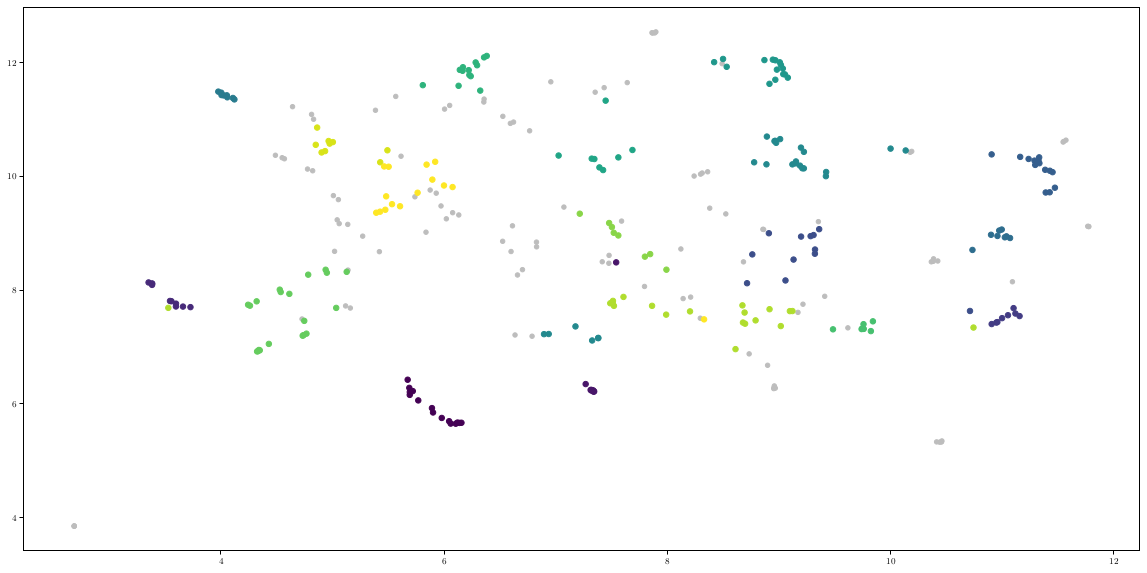

In [168]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=0.0, metric='cosine').fit_transform(sentence_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

#print(result)

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print(max(result.labels))
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=30, cmap='viridis')
#plt.colorbar()

In [169]:
d = {'primitive':defSing, 'cluster':result['labels'], 'x': result['x'], 'y': result['y']}

clusterDF = pd.DataFrame(d)
clusterDF['Doc_ID'] = range(len(clusterDF))

primitivesPerTopic = clusterDF.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [170]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# group by "X" column
groups = primitivesPerTopic.groupby('cluster')
  
labels = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    #print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)

    
    labels.append(matchedKeywords)

    # need to add names to each of the group for visualization

GROUP: -1
grip-ptp
GROUP: 0
assembly-inspection
GROUP: 1
orientation-compare
GROUP: 2
peg-countersink
GROUP: 3
screw-screwdriver
GROUP: 4
orient-transport
GROUP: 5
guide-circular
GROUP: 6
position-lin
GROUP: 7
open-gripper
GROUP: 8
motion-trajectory
GROUP: 9
flip-tilt
GROUP: 10
pour-execute
GROUP: 11
plug-grasp
GROUP: 12
block-pick
GROUP: 13
weld-solder
GROUP: 14
bimanual-perception
GROUP: 15
placement-place
GROUP: 16
retreat-remove
GROUP: 17
insert-insertion


In [171]:
# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
labelsLong = []
clusterDF["keyword"] = ""

for idx, row in clusterDF.iterrows(): 

    for i in range(len(labels)):
        if clusterDF.iloc[idx]["cluster"] == (i-1):
            clusterDF.at[idx, 'keyword'] = labels[i]
            #print(clusterDF.iloc[idx]["keyword"])

print(max(clusterDF["cluster"]))
print(min(clusterDF["x"]))
print(max(clusterDF["x"]))
print(min(clusterDF["y"]))
print(max(clusterDF["y"]))

17
2.6865062713623047
11.774374008178711
3.8508353233337402
12.536848068237305


C:\Users\z0040kve\AppData\Local\Temp/ipykernel_11516/352232466.py:68: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


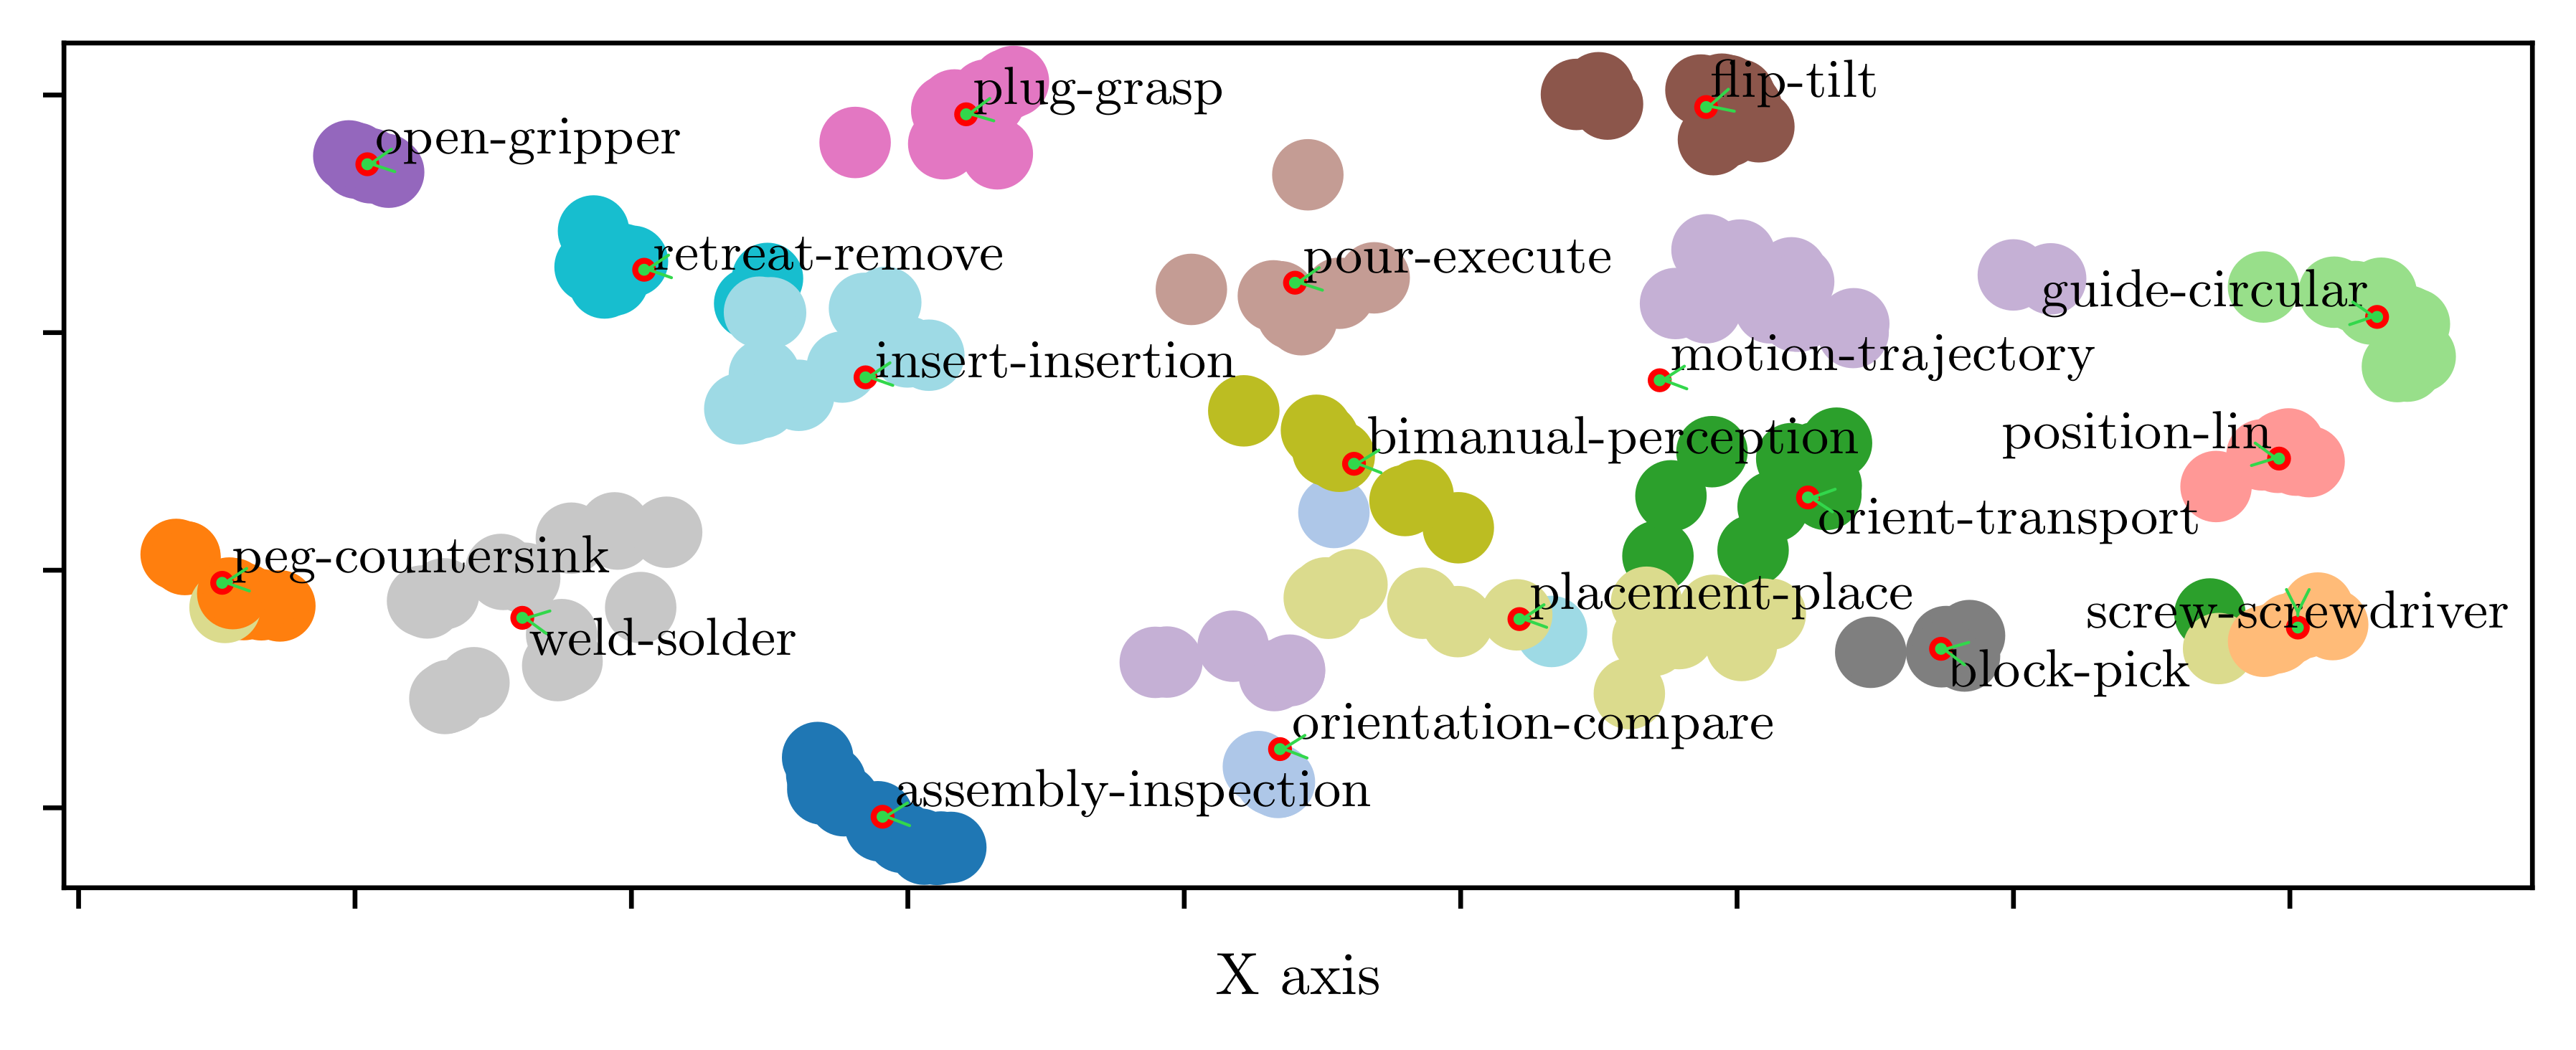

In [172]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from adjustText import adjust_text # to avoid overlapping text

# Latex export
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Visualize clusters with most appearing keywords
# (20,10)
fig, ax = plt.subplots(figsize=(7.4, 2.6), dpi=600)
outliers = clusterDF.loc[clusterDF.cluster == -1, :]
clustered = clusterDF.loc[clusterDF.cluster != -1, :]
plt.rcParams.update({'font.size': 9.5})
#pri

#plt.figure(figsize=(3240/600, 1280/600), dpi=600)

#plt.scatter(outliers.x, outliers.y, color='#F2F2F2', s=30)
plt.scatter(clustered.x, clustered.y, c=clustered.cluster, s=120, cmap='tab20')
#plt.colorbar()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#loop through labels and plot each cluster

# group by "X" column
groups = clustered.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()
texts = []

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()
    
    
    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

#plt.xticks(color='w')
#plt.yticks(color='w')

plt.xlabel("X axis", fontsize=10)

#visualiplt.ylabel("Dimension 2", fontsize=10)

# import tikzplotlib

# tikzplotlib.save("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.tex")
#plt.plot([6.5, 6.5], [8, 14], color='#32d74b', linestyle='--', linewidth=0.6)
#plt.plot([2, 9], [11, 11], color='#32d74b', linestyle='--', linewidth=0.6)
# adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
adjust_text(texts, only_move={'points':'x','texts':'y','objects':'x'}, arrowprops=dict(arrowstyle="->", color='#32d74b', lw=0.5))
#plt.plot([3, 11], [10.5, 10.5], color='#8A8AFF', linestyle='--', linewidth=1)

plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.pgf', dpi=600, bbox_inches = 'tight')
plt.show()

Here we want to perform hiererchical clustering without outliers

In [175]:
embd_list = []

for i in range(len(sentence_embeddings):
    embd_list[i] = i

d = {'primitive':clusterDF['primitive'].to_list(),'cluster':clusterDF['cluster'].to_list(), 'embedding': embd_list}

clustersEmbeddings = pd.DataFrame(d)

clusteredEmb = clustersEmbeddings.loc[clustersEmbeddings.cluster != -1, :]

CLUSTEREDsentence_embeddings = clusteredEmb['embedding'].to_list()

AttributeError: 'numpy.ndarray' object has no attribute 'indices'

In [141]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = CLUSTEREDsentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))

244


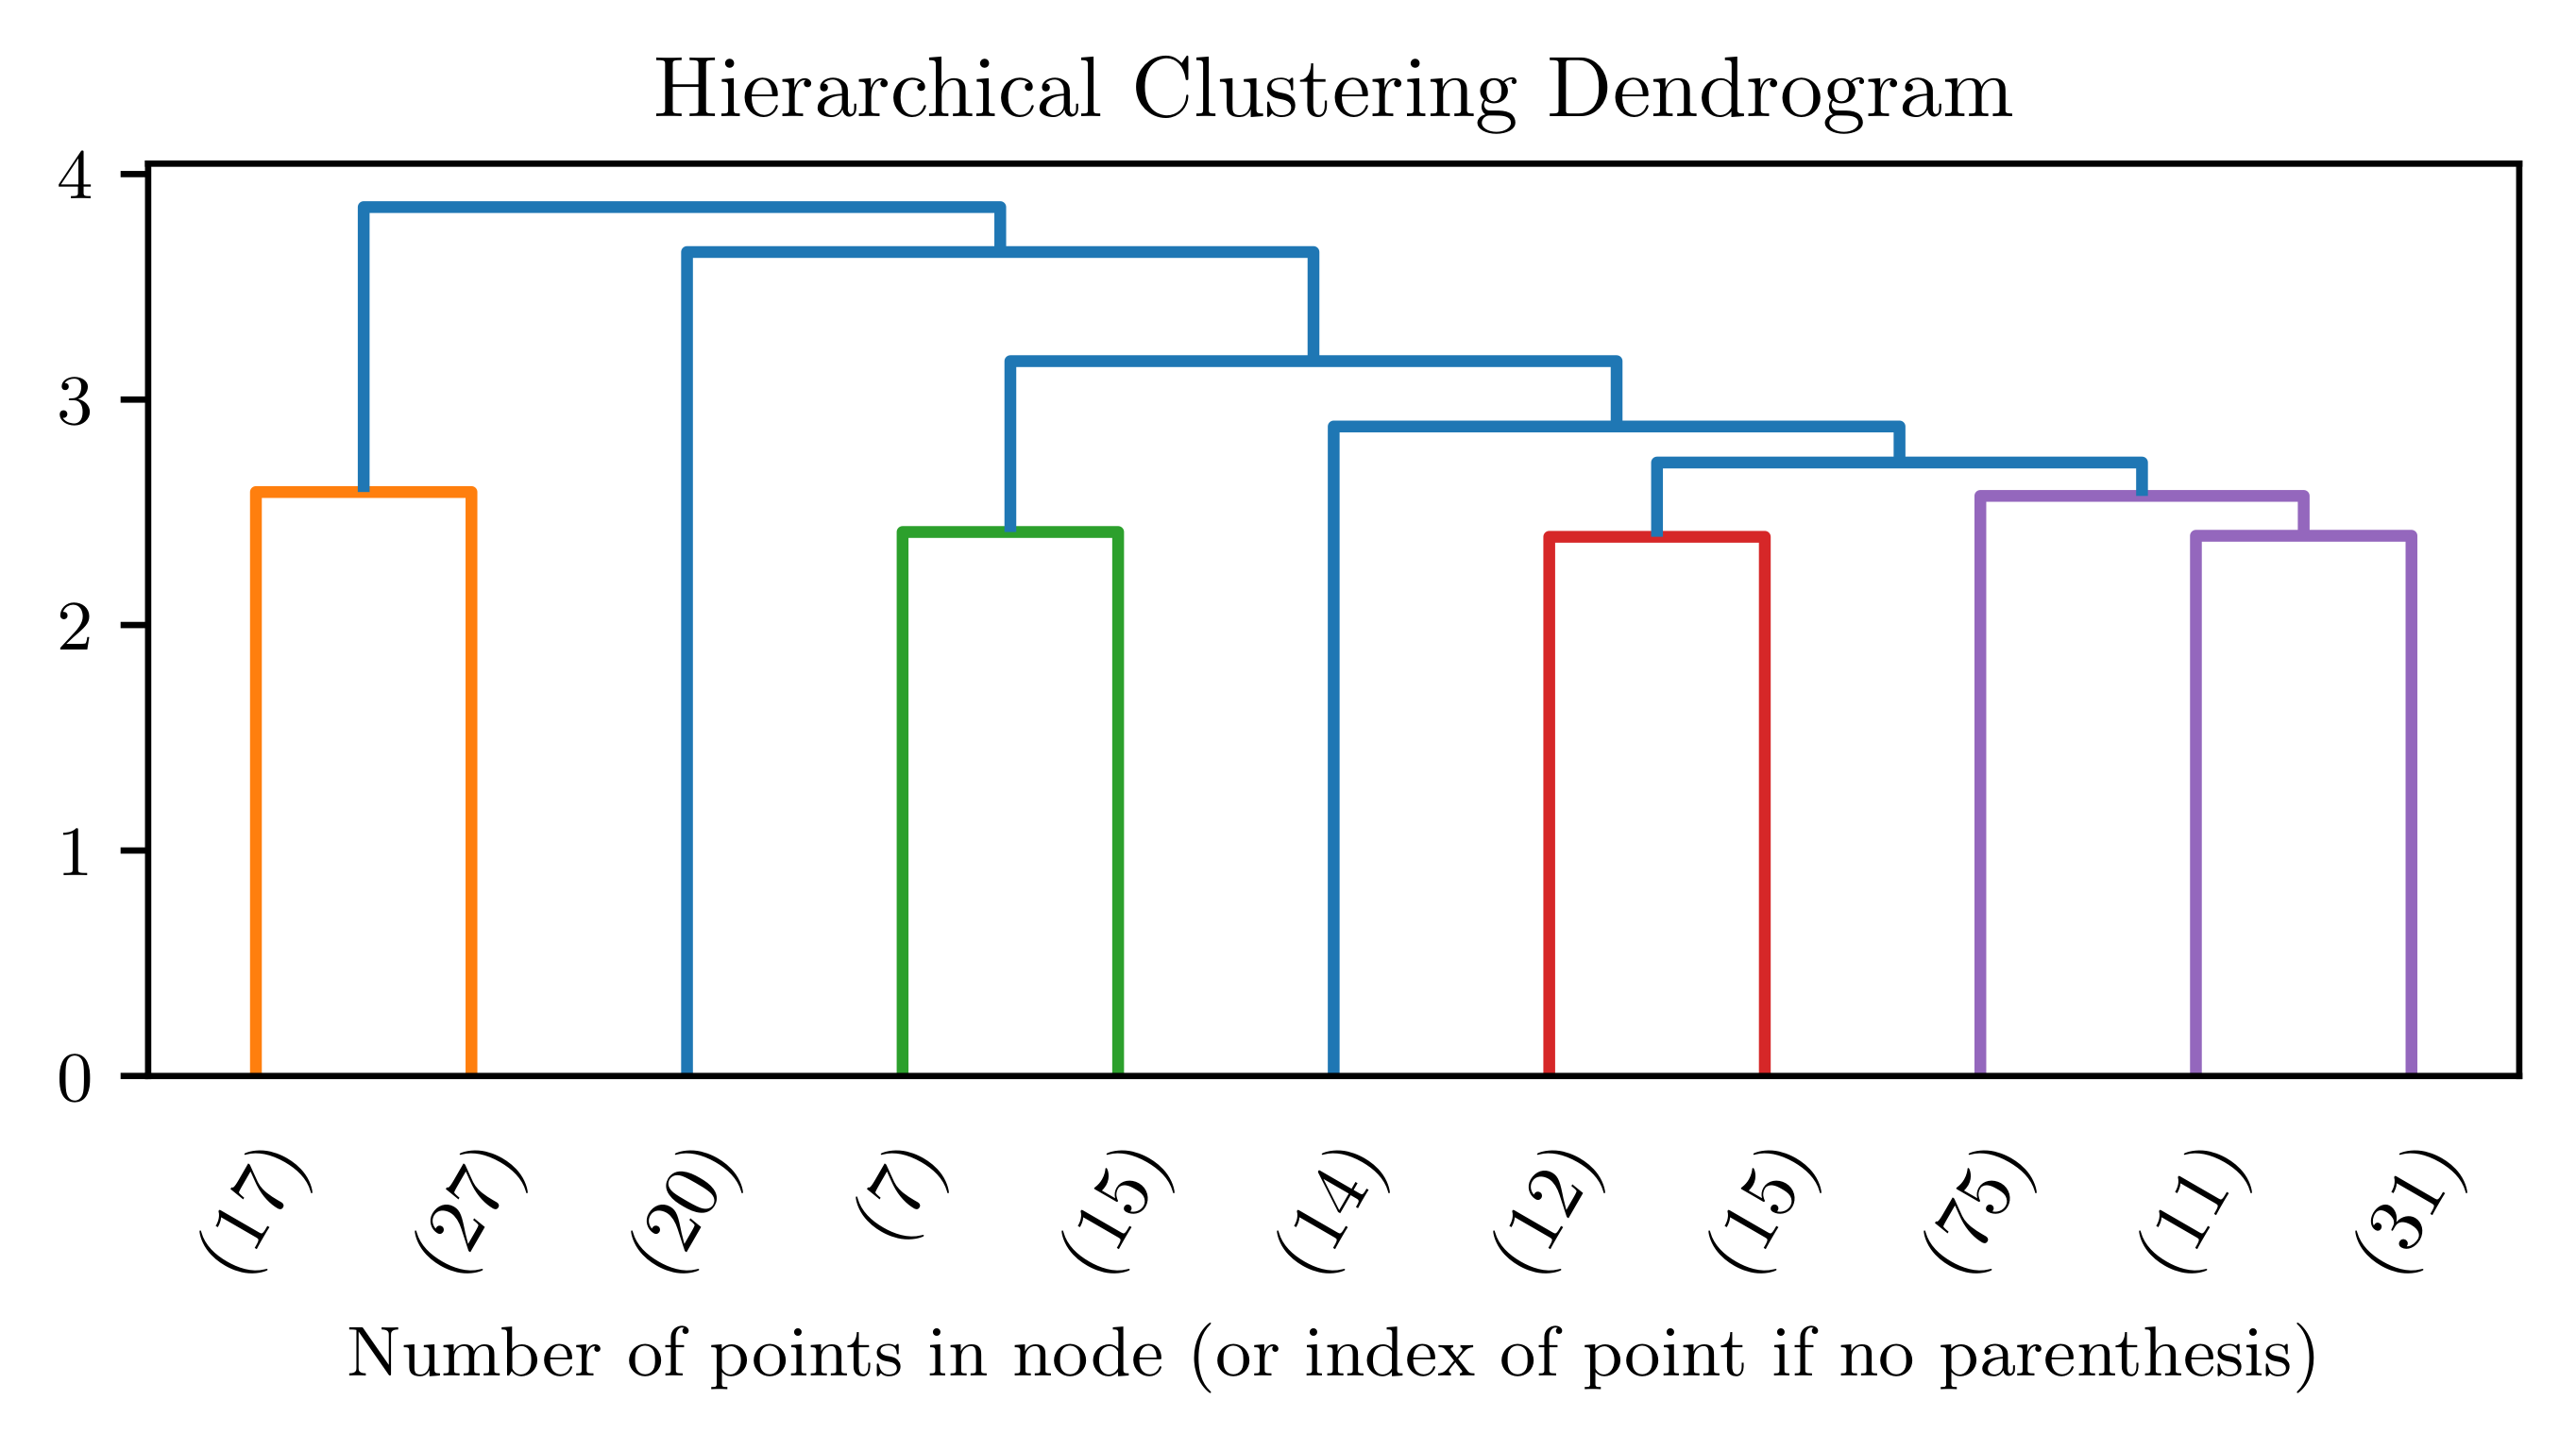

In [143]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendo = dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix, dendo

plt.figure(figsize=(3240/600, 1280/600), dpi=600)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

p = 11
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_rotation=60.,leaf_font_size=10.)
#linkageMatrix, dendoPlot = plot_dendrogram(model, leaf_rotation=60.,leaf_font_size=3.)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/denogrammClusteringRaw.png', dpi=600, bbox_inches = 'tight')
#print(dendoPlot["leaves"])

label = fcluster(linkageMatrix, p, criterion='maxclust')

#print(label)

d = {'primitive': clusteredDef, 'label':label}
#print(d)

hierarchies = pd.DataFrame(d)

#print(hierarchies)


In [144]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# group by "X" column
groups = hierarchies.groupby('label')

labels = []
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words = stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('msmarco-distilbert-base-tas-b')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)


    
    labels.append(matchedKeywords)

    # put keywords on the hierechical clustering

print(labels)

GROUP: 1
['position', 'ptp']
position-ptp
GROUP: 2
['hand', 'movement']
hand-movement
GROUP: 3
['gripper', 'grip']
gripper-grip
GROUP: 4
['compare', 'identity']
compare-identity
GROUP: 5
['object', 'registration']
object-registration
GROUP: 6
['object', 'pick']
object-pick
GROUP: 7
['overhaul', 'inspection']
overhaul-inspection
GROUP: 8
['screwdriver', 'screw']
screwdriver-screw
GROUP: 9
['away', 'push']
away-push
GROUP: 10
['set', 'place']
set-place
GROUP: 11
['feed', 'multi']
feed-multi
['position-ptp', 'hand-movement', 'gripper-grip', 'compare-identity', 'object-registration', 'object-pick', 'overhaul-inspection', 'screwdriver-screw', 'away-push', 'set-place', 'feed-multi']


In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))


temp = {dendoPlot["leaves"][ii]: labels[ii] for ii in range(len(dendoPlot["leaves"]))}

print(len(dendoPlot["leaves"]))

def llf(xx):
    #print("{} - custom label!".format(temp[xx]))
    return "{}".format(temp[xx])

plt.title("Hierarchical Clustering Dendrogram")
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_label_func=llf,leaf_rotation=60.,leaf_font_size=8., show_contracted=True)
plt.xlabel("Keywords expressing each cluster")